In [1]:
import numpy as np
from numpy import log, polyfit, sqrt, std, subtract
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pykalman import KalmanFilter
from datetime import datetime
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import ffn
import warnings

from tqdm import tqdm
from itertools import combinations
warnings.filterwarnings('ignore')


In [106]:
price_df = pd.read_csv('./Data/us_etf_price.csv', parse_dates=['Date'])
etf_info = pd.read_csv('./Data/etfs_details_equity.csv')
price_df = price_df.pivot(columns='tic', index='Date', values='Close')

price_df = price_df.loc['2016':].dropna(axis=1)

price_found = price_df.loc['2021-07-01':'2021-12-31'][price_df.columns]
price_test  = price_df.loc['2022-01-01':'2022-02-01'][price_df.columns]

In [122]:
len(price_found.columns)

876

In [125]:
len(list(combinations( price_found.columns, 2 )))

383250

In [126]:
class kalman_pair:
    
    def __init__ (self, price_found, price_test):
        self.price_found        = np.log(price_found)
        self.price_test         = np.log(price_test)
        self.get_coint_pair()

    def get_coint_pair (self, critical_value=0.05):

        n_ticks     = self.price_found.shape[1]
        tick_names  = list(self.price_found.columns)
        pairs       = []
        p_values    = []

        for pair in tqdm( combinations(tick_names, 2), desc='combination process'):
            result = sm.tsa.stattools.coint(self.price_found[pair[0]], self.price_found[pair[1]])
            pvalue = result[1]
            
            if pvalue <= critical_value:
                pairs.append(pair)
                p_values.append(pvalue)

        coint_df = pd.DataFrame(data=[pairs, p_values], index=[['pairs','p_values']]).T

        self.coint_df = coint_df

        return coint_df

    def kf_avg (self, x):
    
        kf = KalmanFilter(transition_matrices = [1],
                        observation_matrices= [1],
                        initial_state_mean = 0,
                        initial_state_covariance = 1,
                        observation_covariance = 1,
                        transition_covariance = 0.01)

        state_means, _ = kf.filter(x)
        state_means = pd.Series(state_means.reshape(-1), index=x.index)

        return state_means

    def kf_regress (self, x, y):

        delta = 1e-4
        trans_cov = delta / (1-delta) * np.eye(2) # random walk shakes
        observing_mat = np.expand_dims(np.c_[x.values, np.ones(len(x))], axis=1)

        kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                            initial_state_mean=[0,0],
                            initial_state_covariance=np.ones((2, 2)),
                            transition_matrices=np.eye(2),
                            observation_matrices=observing_mat,
                            observation_covariance=2,
                            transition_covariance=trans_cov)
        state_means, state_covs = kf.filter(y.values)

        return state_means

    def half_life(self, spread):

        spread_lag = spread.shift(1)
        spread_lag.iloc[0] = spread_lag.iloc[1]
        
        spread_ret = spread - spread_lag
        spread_ret.iloc[0] = spread_ret.iloc[1]
        
        spread_lag2 = sm.add_constant(spread_lag)
        
        model = sm.OLS(spread_ret,spread_lag2)
        res = model.fit()
        halflife = int(round(-np.log(2) / res.params[1],0))
    
        if halflife <= 0:
            halflife = 1
        
        return halflife
        
    def back_test (self, asset_1, asset_2, opt='found'):

        if opt == 'found':
            x = self.price_found[asset_1]
            y = self.price_found[asset_2]
        elif opt == 'test':
            x = self.price_test[asset_1]
            y = self.price_test[asset_2]

        df = pd.DataFrame({'y': y, 'x': x})

        state_means = self.kf_regress(self.kf_avg(x), self.kf_avg(y))

        df['hr'] = - state_means[:,0]
        df['spread'] = df.y + (df.x * df.hr)

        halflife = self.half_life(df['spread'])
        mean_spread = df.spread.rolling(halflife).mean()
        std_spread = df.spread.rolling(halflife).std()

        df['z_score'] = (df.spread - mean_spread)/std_spread
        
        '''enter, exit based on Z score'''
        enter = 2
        exit = 0
        
        df['long_enter'] = (df.z_score < -enter) & (df.z_score.shift(1) > -enter)
        df['long_exit']  = (df.z_score > -exit ) & (df.z_score.shift(1) < -exit )
        df['num_units_long'] = np.nan
        df.loc[df['long_enter'],'num_units_long'] = 1 
        df.loc[df['long_exit'],'num_units_long'] = 0
        df['num_units_long'][0] = 0 
        df['num_units_long'] = df['num_units_long'].fillna(method='pad')

        df['short_enter'] = (df.z_score > enter) & (df.z_score.shift(1) < enter)
        df['short_exit']  = (df.z_score < exit ) & (df.z_score.shift(1) > exit )
        df.loc[df['short_enter'],'num_units_short'] = -1 
        df.loc[df['short_exit'],'num_units_short'] = 0
        df['num_units_short'][0] = 0 
        df['num_units_short'] = df['num_units_short'].fillna(method='pad')

        df['num_Units'] = df['num_units_long'] + df['num_units_short']
        df['spread_pct_ch'] = (df['spread'] - df['spread'].shift(1)) / ((df['x'] * abs(df['hr'])) + df['y'])

        df['port_rets'] = df['spread_pct_ch'] * df['num_Units'].shift(1)
        df['cum_rets'] = df['port_rets'].cumsum()
        df['cum_rets'] = df['cum_rets'] + 1

        try:
            sharpe = ((df['port_rets'].nanmean() / df['port_rets'].nanstd()))

        except ZeroDivisionError:
            sharpe = 0.0

        return df, sharpe
            

In [127]:
kp = kalman_pair(price_found, price_test)

combination process: 383250it [14:48, 431.34it/s]


In [128]:
kp.coint_df

,pairs,p_values
0,"(AADR, BBH)",0.011978
1,"(AADR, BIB)",0.028286
2,"(AADR, BIS)",0.030595
3,"(AADR, CHAD)",0.043589
4,"(AADR, CID)",0.024685
...,...,...
31731,"(XNTK, XTN)",0.040761
31732,"(XPH, XPP)",0.029602
31733,"(XPH, XSOE)",0.022683
31734,"(XPH, YINN)",0.028685


In [129]:
kp.coint_df.to_csv('coint_df(21).csv')

In [130]:
reg_pair = []
reg_data = []
reg_sharpe = []

for idx, pair in tqdm(enumerate(kp.coint_df['pairs'].values)):
    asset_1 = pair.item()[0]
    asset_2 = pair.item()[1]

    tmp, sharpe = kp.back_test(asset_1, asset_2, opt='test')
    #if sharpe > 0.5 and tmp['cum_rets'][-1] > 1.105:
    reg_data.append(tmp['cum_rets'])
    reg_sharpe.append(sharpe)
    reg_pair.append(pair)


result2 = pd.DataFrame({'pair':reg_pair, 'data':reg_data, 'sharpe':reg_sharpe})

result2
            


31736it [05:16, 100.27it/s]


,pair,data,sharpe
0,"[(AADR, BBH)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
1,"[(AADR, BIB)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
2,"[(AADR, BIS)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
3,"[(AADR, CHAD)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
4,"[(AADR, CID)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
...,...,...,...
31731,"[(XNTK, XTN)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
31732,"[(XPH, XPP)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
31733,"[(XPH, XSOE)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
31734,"[(XPH, YINN)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0


In [133]:
result2

,pair,data,sharpe
0,"[(AADR, BBH)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
1,"[(AADR, BIB)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
2,"[(AADR, BIS)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
3,"[(AADR, CHAD)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
4,"[(AADR, CID)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
...,...,...,...
31731,"[(XNTK, XTN)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
31732,"[(XPH, XPP)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
31733,"[(XPH, XSOE)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0
31734,"[(XPH, YINN)]",Date 2022-01-03 NaN 2022-01-04 1.0 2022-...,0.0


In [131]:
result2.iloc[np.where(result2['sharpe'] != 0)].mean()

pair      NaN
data      NaN
sharpe    NaN
dtype: object

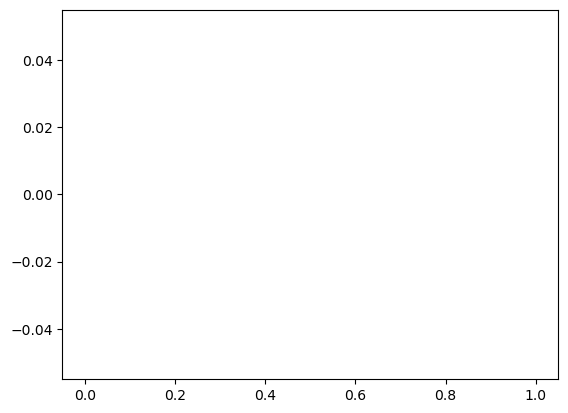

In [134]:
%matplotlib inline
plt.hist(result2.iloc[np.where(result2['sharpe'] != 0)]['sharpe'], bins=30)
plt.show()

In [84]:
result.to_csv('result(16~21).csv')

In [87]:
result2.to_csv('result(16~21).csv')

In [26]:
asset_1 = kp.coint_df['pairs'].loc[2].item()[0]
asset_2 = kp.coint_df['pairs'].loc[2].item()[1]
asset_1

'AAXJ'

In [ ]:
pairs = [('QID', 'DXD'), ('SPXS', 'SDOW'), ('SPDN', 'SH')]

In [27]:
kp.back_test(asset_1, asset_2)

(                   y         x        hr    spread   z_score  long_enter  \
 Date                                                                       
 2016-01-04  2.574900  3.948355 -0.353052  1.180926       NaN       False   
 2016-01-05  2.598235  3.950282 -0.420211  0.938284       NaN       False   
 2016-01-06  2.590767  3.930648 -0.448343  0.828487       NaN       False   
 2016-01-07  2.535283  3.902377 -0.463345  0.727135       NaN       False   
 2016-01-08  2.545531  3.894063 -0.472889  0.704072 -0.884241       False   
 ...              ...       ...       ...       ...       ...         ...   
 2021-12-27  3.048562  4.415220 -0.570352  0.530330 -1.197957       False   
 2021-12-28  3.053765  4.412920 -0.570548  0.535983 -0.502498       False   
 2021-12-29  3.027522  4.408669 -0.570720  0.511406 -1.524732       False   
 2021-12-30  3.040084  4.420646 -0.570875  0.516449 -0.837445       False   
 2021-12-31  3.038792  4.415220 -0.571015  0.517636 -0.457633       False   

In [167]:
x = kp.price_found[asset_1]
y = kp.price_found[asset_2]

df = pd.DataFrame({'y': y, 'x': x})

state_means = kp.kf_regress(kp.kf_avg(asset_1), kp.kf_avg(asset_2))

df['hr'] = - state_means[:,0]
df['spread'] = df.y + (df.x * df.hr)
df

,y,x,hr,spread
Date,,,,
2016-01-04,3.948355,3.629925,-0.559979,1.915674
2016-01-05,3.950282,3.629925,-0.674190,1.503022
2016-01-06,3.930648,3.614695,-0.722101,1.320473
2016-01-07,3.902377,3.614695,-0.748254,1.197668
2016-01-08,3.894063,3.614695,-0.764767,1.129664
...,...,...,...,...
2021-12-27,4.415220,4.158258,-0.864560,0.820155
2021-12-28,4.412920,4.164803,-0.864453,0.812644
2021-12-29,4.408669,4.160912,-0.864332,0.812260


In [168]:
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    
    spread_lag2 = sm.add_constant(spread_lag)
     
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
 
    if halflife <= 0:
        halflife = 1
    return halflife

halflife = half_life(df['spread'])

In [169]:
mean_spread = df.spread.rolling(halflife).mean()
std_spread = df.spread.rolling(halflife).std()

df['z_score'] = (df.spread - mean_spread)/std_spread

In [170]:
'''enter, exit based on Z score'''
enter = 2
exit = 0

In [172]:
df['long_enter'] = (df.z_score < -enter) & (df.z_score.shift(1) > -enter)
df['long_exit']  = (df.z_score > -exit ) & (df.z_score.shift(1) < -exit )
df['num_units_long'] = np.nan
df.loc[df['long_enter'],'num_units_long'] = 1 
df.loc[df['long_exit'],'num_units_long'] = 0
df['num_units_long'][0] = 0 
df['num_units_long'] = df['num_units_long'].fillna(method='pad')

In [179]:
df['short_enter'] = (df.z_score > enter) & (df.z_score.shift(1) < enter)
df['short_exit']  = (df.z_score < exit ) & (df.z_score.shift(1) > exit )
df.loc[df['short_enter'],'num_units_short'] = -1 
df.loc[df['short_exit'],'num_units_short'] = 0
df['num_units_short'][0] = 0 
df['num_units_short'] = df['num_units_short'].fillna(method='pad')

In [181]:
df['num_Units'] = df['num_units_long'] + df['num_units_short']
df['spread_pct_ch'] = (df['spread'] - df['spread'].shift(1)) / ((df['x'] * abs(df['hr'])) + df['y'])
df['port_rets'] = df['spread_pct_ch'] * df['num_Units'].shift(1)

In [183]:
df['cum_rets'] = df['port_rets'].cumsum()
df['cum_rets'] = df['cum_rets'] + 1

In [186]:
try:
    sharpe = ((df['port_rets'].mean() / df['port_rets'].std()) * sqrt(252))
except ZeroDivisionError:
    sharpe = 0.0

In [188]:
df['cum_rets'], sharpe

(Date
 2016-01-04    NaN
 2016-01-05    1.0
 2016-01-06    1.0
 2016-01-07    1.0
 2016-01-08    1.0
              ... 
 2021-12-27    1.0
 2021-12-28    1.0
 2021-12-29    1.0
 2021-12-30    1.0
 2021-12-31    1.0
 Name: cum_rets, Length: 1511, dtype: float64,
 0.0)

In [127]:
kp.price_found[asset_1]

Date
2016-01-04    3.629925
2016-01-05    3.629925
2016-01-06    3.614695
2016-01-07    3.614695
2016-01-08    3.614695
                ...   
2021-12-27    4.158258
2021-12-28    4.164803
2021-12-29    4.160912
2021-12-30    4.160288
2021-12-31    4.162782
Name: AADR, Length: 1511, dtype: float64

In [130]:
spread = kp.price_found[asset_1] - kp.price_found[asset_2]
hurst(kp.price_found[asset_1] - kp.price_found[asset_2])
half_life(spread)

KeyError: 1

In [125]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
 
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
 
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
 
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

#--------------------------------------------------------------------------------------
 
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    
    spread_lag2 = sm.add_constant(spread_lag)
     
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
 
    if halflife <= 0:
        halflife = 1
    return halflife